# Variational Autoencoder (V)
This notebook trains the variational autoencoder using data collected from 10K random rollouts

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import pickle
from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras

In [2]:
tf.__version__

'2.0.0-alpha0'

## DATA

Load pickled data using tf.data.Dataset

In [3]:
DATASET_DIR = '../src/dataset'

In [4]:
filenames = glob('{}/*'.format(DATASET_DIR))
len(filenames)

10000

In [5]:
rollout_data = pickle.load(open(filenames[0], 'rb'))

In [30]:
rollout_data[0][0].shape, len(rollout_data)

((96, 96, 3), 1000)

We first load 30% random files to train and test out autoencoder

In [6]:
random_fnames = np.random.choice(filenames, int(len(filenames)*0.03))
len(random_fnames)

300

Each rollout is saved as a pickled list of tuple(state, action, next_state). Let load the data and plot a random state.

In [7]:
dataset = [row[0] for fname in random_fnames for row in pickle.load(open(fname, 'rb'))]
len(dataset)

300000

In [29]:
dataset[0].shape, len(dataset)

((96, 96, 3), 300000)

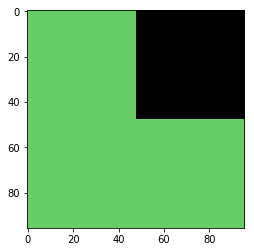

In [37]:
# plt.imshow(dataset[np.random.randint(0, len(dataset))])
plt.imshow(rollout_data[241][0])
plt.show()

we use Dataset API to load and shuffle the data

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(dataset)

In [ ]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# MODEL

Variational Autoencoder consists of encoder and decoder network just like vanilla autoencoder but instead of directly learning the latent vector Z, the network learns the gaussian distribution mean and diagonal variance $(\mu, \sigma^2I)$

In [3]:
input_shape = (64,64,3)
num_latent_vec = 32

### Encoder Network

We use conv layers for the encoder network

In [57]:
encoder_input = keras.Input(shape=(input_shape), name='encoder_input_image')
x = keras.layers.Conv2D(32, 4, (2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(64, 4, (2,2), activation='relu')(x)
x = keras.layers.Conv2D(128, 4, (2,2), activation='relu')(x)
x = keras.layers.Conv2D(256, 4, (2,2), activation='relu')(x)
encoder_last_conv_shape = K.int_shape(x)[1:]
print("encoder_last_conv_shape: {}".format(encoder_last_conv_shape))
x = keras.layers.Flatten()(x)
mu = keras.layers.Dense(num_latent_vec, activation='linear', name="mean")(x)
logvar = keras.layers.Dense(num_latent_vec, activation='linear', name="variance")(x)

encoder = keras.Model(encoder_input, [mu, logvar], name='encoder')
encoder.summary()

encoder_last_conv_shape: (2, 2, 256)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_image (InputLayer [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 31, 31, 32)   1568        encoder_input_image[0][0]        
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 14, 14, 64)   32832       conv2d_62[0][0]                  
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 6, 6, 128)    131200      conv2d_63[0][0]                  
_______________________________________________________

After the network has learned the gaussian params, we need a way to sample the latent vector. We do this by creating a Lambda layer that accepts mean and variance as input and sampled latent vector as output.

In [58]:
def sample(args):
    mu, logvar = args
    # reparameterizaton trick: allows gradients to pass through the sample
    # 1. sample from unit gaussian, then
    # 2. multiply it with standard deviation and add mean
    e = tf.random.normal(shape=(K.shape(mu)[0], num_latent_vec))
    return e * tf.math.exp(logvar) + mu

In [45]:
sampled_latent_vector = keras.layers.Lambda(sample)([mu, logvar])

### Decoder Network
For Decoder network, we sample the latent vector from the gaussian distribution and use it as input for our decoder network which is make of Deconv layers

In [56]:
decoder_input = keras.layers.Input(shape=K.int_shape(sampled_latent_vector)[1:], name='decoder_input')
x = keras.layers.Dense(np.prod(encoder_last_conv_shape))(decoder_input)
x = keras.layers.Reshape((1,1,np.prod(encoder_last_conv_shape)))(x)
x = keras.layers.Conv2DTranspose(128, 5, (2,2), activation='relu')(x)
x = keras.layers.Conv2DTranspose(64, 5, (2,2), activation='relu')(x)
x = keras.layers.Conv2DTranspose(32, 6, (2,2), activation='relu')(x)
decoder_output = keras.layers.Conv2DTranspose(3, 6, (2,2), activation='sigmoid')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              33792     
_________________________________________________________________
reshape_11 (Reshape)         (None, 1, 1, 1024)        0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 5, 5, 128)         3276928   
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 13, 13, 64)        204864    
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 30, 30, 32)        73760     
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 64, 64, 3)         3459

In [ ]:
class VAELossLayer(keras.layers.Layer):
    def calculate_loss(self, original, decoded):
        original = K.flatten(original)
        decoded = K.flatten(original)
        
        
    
    def call(self, inputs):
        x, decoded = inputs
        loss = self.calculate_loss(x, decoded)
        self.add_loss(loss, inputs=inputs)
        return x